# $$ \hspace{7.5cm} \text{Gaussian Process Regression With Fractal-type kernel: Implementation in Python}$$

## Importing Essential Libraries

In [ ]:
import pandas as pd   # Data handling (tables, CSVs, etc.)
import numpy as np    # Numerical operations (arrays, math)
from matplotlib import pyplot as plt  # Plotting and visualization

## Load and Preprocess Crude Oil Data

In [ ]:
# Load dataset from CSV
df = pd.read_csv('/content/Crude Oil WTI Futures Historical Data.csv')

# Reverse DataFrame so oldest date is first, reset index
df = df.iloc[::-1].reset_index(drop=True)

# Normalize index to create 'date_scaled' from 0 to 1
n = len(df)
df['date_scaled'] = df.index / (n - 1)

# Display the DataFrame
df

,Date,Price,Open,High,Low,Vol.,Change %,date_scaled
0,10/13/2021,79.82,79.83,80.36,78.78,304.96K,-0.13%,0.000000
1,10/14/2021,80.77,79.94,81.14,79.79,300.57K,1.19%,0.004762
2,10/15/2021,81.73,80.93,82.00,80.86,284.73K,1.19%,0.009524
3,10/18/2021,81.69,82.00,83.18,81.21,501.07K,-0.05%,0.014286
4,10/19/2021,82.44,81.58,82.99,81.08,531.47K,0.92%,0.019048
...,...,...,...,...,...,...,...,...
206,07/25/2022,94.42,92.83,94.62,90.79,92.70K,2.15%,0.980952
207,07/26/2022,92.88,93.95,96.60,92.64,89.07K,-1.63%,0.985714
208,07/27/2022,95.29,93.51,96.53,92.30,105.40K,2.59%,0.990476
209,07/28/2022,94.65,96.09,97.82,94.28,96.14K,-0.67%,0.995238


## Priestley-Chao Mean Estimation and Residual Variance Calculation

Shape of X_train: (11,)
Shape of Y_train: (11,)
Shape of X_test: (200,)
Shape of Y_test: (200,)


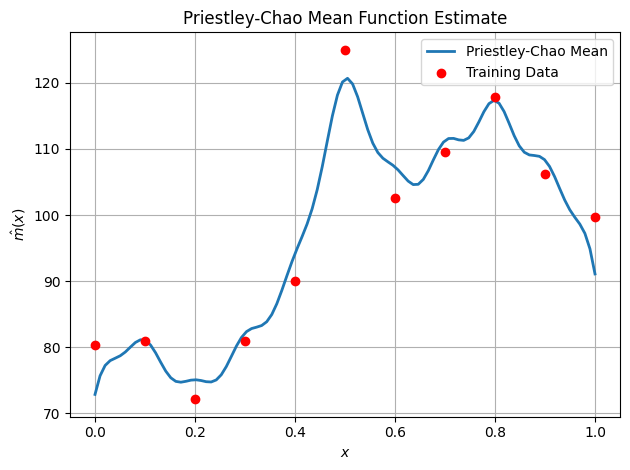

Variance of e_s: 18.56867787899579


In [ ]:
# Extract normalized date and 'High' price as NumPy arrays
X = df['date_scaled'].to_numpy()
Y = df['High'].to_numpy()

# Define 11 equally spaced training nodes and corresponding Y-values
xB = np.linspace(0, 1, 11)
indices = np.linspace(0, len(Y) - 1, 11, dtype=int)
yB = Y[indices]

# Create a mask for training points using isclose (to handle float precision)
train_mask = np.isclose(X[:, None], xB, atol=1e-6).any(axis=1)

# Split into training and test sets
X_train = X[train_mask]
Y_train = Y[train_mask]
X_test = X[~train_mask]
Y_test = Y[~train_mask]

# Debug print shapes
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

# --- Priestley-Chao Mean Function ---
def priestley_chao_mean(x, xB, yB, d=0.05):
    coeff = 1 / (10 * np.sqrt(2 * np.pi) * d)
    return coeff * np.sum(yB[:, None] * np.exp(-((x - xB[:, None])**2) / (2 * d**2)), axis=0)

# Estimate mean at 100 evenly spaced test points
x_test = np.linspace(0, 1, 100)
m_values = priestley_chao_mean(x_test, xB, yB, d=0.05)

# Plot the mean function and training data
plt.plot(x_test, m_values, label="Priestley-Chao Mean", linewidth=2)
plt.scatter(xB, yB, color='red', label="Training Data", zorder=5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$\hat{m}(x)$")
plt.title("Priestley-Chao Mean Function Estimate")
plt.grid(True)
plt.tight_layout()
plt.savefig("priestley_chao_mean.png", dpi=300, bbox_inches="tight")
plt.show()

# Compute residuals at training nodes
e_s = yB - priestley_chao_mean(xB, xB, yB, d=0.05)

# Estimate variance of the residuals
variance_e_s = np.var(e_s)
sigma2 = variance_e_s
print("Variance of e_s:", variance_e_s)

## Install Optuna for Hyperparameter Optimization

In [ ]:
# Install the Optuna library for hyperparameter optimization
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.9 MB/s eta 0:00:00


## Construction and Optimization of a Fractal-Type Kernel for Gaussian Process Regression

In [36]:
# === Imports ===
from numpy.linalg import inv
from scipy.integrate import trapezoid
import optuna

# === Define Fractal Basis Functions ===
def u_i(i, x): return x**(i-1)

def r(x, i):
    x = np.asarray(x)
    return u_i(i, 0) + (u_i(i, 1) - u_i(i, 0)) * x

def L_j_inv(j, x, x_nodes):
    x = np.asarray(x)
    denominator = x_nodes[j] - x_nodes[j-1]
    if np.abs(denominator) < 1e-12:
        print(f"Warning: Division by zero in L_j_inv for interval {j}.")
    return (x - x_nodes[j - 1]) / denominator

# === Compute Fractal Basis F_i ===
def compute_F_ui(i, s_list, x_nodes, resolution=1000, tol=1e-8, max_iter=1000):
    X = np.linspace(0, 1, resolution)
    F_old = u_i(i, X)
    num_intervals = len(x_nodes) - 1

    for k in range(max_iter):
        F_new = np.zeros_like(F_old)
        for j in range(1, num_intervals + 1):
            mask = (X >= x_nodes[j-1] - tol) & (X <= x_nodes[j] + tol)
            if j == num_intervals:
                mask = (X >= x_nodes[j-1] - tol) & (X <= x_nodes[j] + tol)
            x_sub = X[mask]
            if len(x_sub) == 0: continue
            xi = np.clip(L_j_inv(j, x_sub, x_nodes), 0, 1)
            F_L_inv = np.interp(xi, X, F_old)
            s_val = s_list[j - 1]
            F_new[mask] = s_val * (F_L_inv - r(xi, i)) + u_i(i, x_sub)
        if np.linalg.norm(F_new - F_old, np.inf) < tol: break
        F_old = F_new
    return X, F_new

# === Compute Gram Matrix A and Inverse B ===
def compute_A_and_B_optimized(eta, s_lists, x_nodes):
    X_grid = np.linspace(0, 1, 1000)
    F_matrix = [compute_F_ui(i+1, s_lists[i], x_nodes, len(X_grid))[1] for i in range(eta)]
    F_matrix = np.array(F_matrix)
    A = trapezoid(F_matrix[:, None, :] * F_matrix[None, :, :], X_grid, axis=2)
    A += 1e-10 * np.eye(A.shape[0])
    B = inv(A)
    return A, B, F_matrix, X_grid

# === Fractal Kernel Function ===
def fractal_kernel(x, x_prime, F_matrix, B, X_grid, theta):
    x, x_prime = np.atleast_1d(x), np.atleast_1d(x_prime)
    F_x = np.array([np.interp(x, X_grid, F_matrix[i]) for i in range(F_matrix.shape[0])])
    F_xp = np.array([np.interp(x_prime, X_grid, F_matrix[i]) for i in range(F_matrix.shape[0])])
    K = theta * F_x.T @ B @ F_xp
    return K[0, 0] if x.size == 1 and x_prime.size == 1 else K

# === Optimization with Optuna ===
x_nodes = xB  # Use training points as node grid

def objective(trial):
    eta = 11
    num_intervals = len(x_nodes) - 1
    s_lists = [[trial.suggest_float(f"s_{i}_interval_{j}", -0.99, 0.99) for j in range(num_intervals)] for i in range(eta)]
    theta = trial.suggest_float("theta", 0.01, 0.99)

    try:
        A, B, F_matrix, X_grid = compute_A_and_B_optimized(eta, s_lists, x_nodes)
        K_train = fractal_kernel(X_train, X_train, F_matrix, B, X_grid, theta)
        K_train += sigma2 * np.eye(len(X_train)) + 1e-10 * np.eye(len(X_train))
        L = np.linalg.cholesky(K_train)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, e_s))
        logdet = 2 * np.sum(np.log(np.diag(L)))
        log_likelihood = -0.5 * e_s.T @ alpha - 0.5 * logdet - len(X_train) / 2 * np.log(2 * np.pi)
        return log_likelihood
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Optimization error: {e}")
        return -np.inf

# === Run Study ===
try:
    study
except NameError:
    study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=80, show_progress_bar=True)

# === Extract Best Parameters ===
print("Best log marginal likelihood:", study.best_value)
print("Best parameters:", study.best_params)
best_theta = study.best_params["theta"]

eta = 11
num_intervals = len(x_nodes) - 1
best_s_lists = [[study.best_params[f"s_{i}_interval_{j}"] for j in range(num_intervals)] for i in range(eta)]

  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-05-14 06:58:59,874] Trial 3921 finished with value: -30.02475709650689 and parameters: {'s_0_interval_0': -0.5649210483415544, 's_0_interval_1': 0.36791145587977986, 's_0_interval_2': 0.8647816901011787, 's_0_interval_3': 0.7885525117773562, 's_0_interval_4': -0.8354349003140193, 's_0_interval_5': -0.5360283444118229, 's_0_interval_6': 0.9223118493357662, 's_0_interval_7': -0.31690327677619723, 's_0_interval_8': -0.09933485878621556, 's_0_interval_9': -0.33748705208647367, 's_1_interval_0': 0.8972399291117235, 's_1_interval_1': 0.2832863967278343, 's_1_interval_2': -0.8383330285131604, 's_1_interval_3': -0.7807288088636589, 's_1_interval_4': -0.5058034527234926, 's_1_interval_5': 0.8920346672475249, 's_1_interval_6': -0.8521094792092289, 's_1_interval_7': 0.7965295931555394, 's_1_interval_8': -0.9897213609033493, 's_1_interval_9': 0.4109023619053842, 's_2_interval_0': -0.13750245516233084, 's_2_interval_1': 0.9248708855582016, 's_2_interval_2': -0.8899134870904913, 's_2_interva

## Visualization of Optuna Optimization Results

In [37]:
# Plot optimization history
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

## Plotting Fractal Basis Functions $F[u_i](x)$ for Various $i$

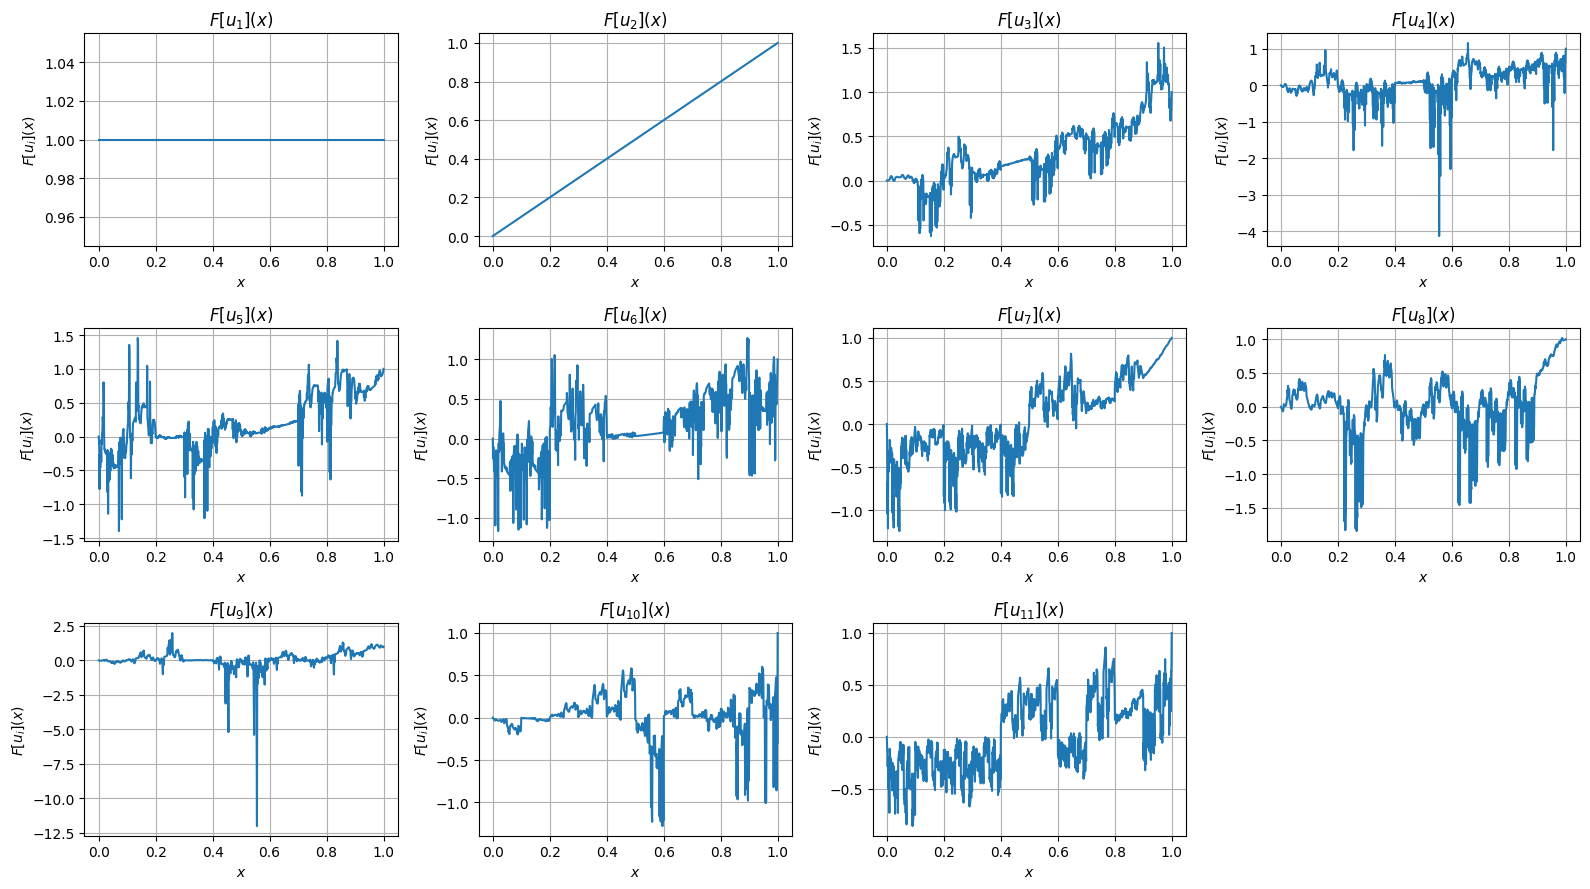

In [38]:
# Define the number of basis functions (eta)
eta = 11  # Assuming eta corresponds to the number of training nodes/basis functions

# --- Recompute F_matrix and X_grid using the best parameters ---
# Ensure x_nodes (xB) and best_s_lists are available from the optimization step
try:
    # x_nodes should be xB as defined in the optimization section
    # best_s_lists should be populated from study.best_params
    # Ensure these variables are accessible in this scope
    if 'xB' not in locals() and 'xB' not in globals():
         raise NameError("xB is not defined. Please run the data loading and preprocessing cells.")
    if 'best_s_lists' not in locals() and 'best_s_lists' not in globals():
         raise NameError("best_s_lists is not defined. Please run the Optuna optimization cell successfully.")

    # Compute the F_matrix and X_grid using the best s_lists
    A_best, B_best, best_F_matrix, best_X_grid = compute_A_and_B_optimized(eta, best_s_lists, xB)

except NameError as e:
    print(f"Error: Required variables not found. {e}")
    print("Please ensure the preceding cells defining xB and running Optuna have completed successfully.")
    # Optionally exit or skip plotting
    # raise # uncomment to stop execution
except Exception as e:
    print(f"An error occurred while recomputing basis functions: {e}")
    # Optionally exit or skip plotting
    # raise # uncomment to stop execution


# Define indices for plotting F_[u_i] (e.g., plot all eta basis functions)
indices_to_plot = list(range(eta))  # Plot all basis functions

# Determine the number of rows and columns for the subplot grid
# Simple approach: square layout
n_cols = int(np.ceil(np.sqrt(len(indices_to_plot))))
n_rows = int(np.ceil(len(indices_to_plot) / n_cols))

plt.figure(figsize=(n_cols * 4, n_rows * 3))  # Adjust figure size as needed

# Plot each F_[u_i] basis function in a separate subplot
# Only attempt plotting if best_F_matrix and best_X_grid were successfully computed
if 'best_F_matrix' in locals() and 'best_X_grid' in locals():
    for k, i in enumerate(indices_to_plot):
        ax = plt.subplot(n_rows, n_cols, k + 1)  # k+1 for 1-based subplot index

        # F_matrix[i, :] contains the values of F_{u_{i+1}} on the X_grid
        ax.plot(best_X_grid, best_F_matrix[i, :])

        ax.set_xlabel('$x$')
        ax.set_ylabel('$F[u_i](x)$')
        ax.set_title(f'$F[u_{{{i+1}}}] (x)$')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("all_fractal_basis_functions.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("Skipping basis function plotting due to errors in recomputing F_matrix and X_grid.")

## Predictive Distribution and Model Evaluation with Fractal Kernel-based GPR

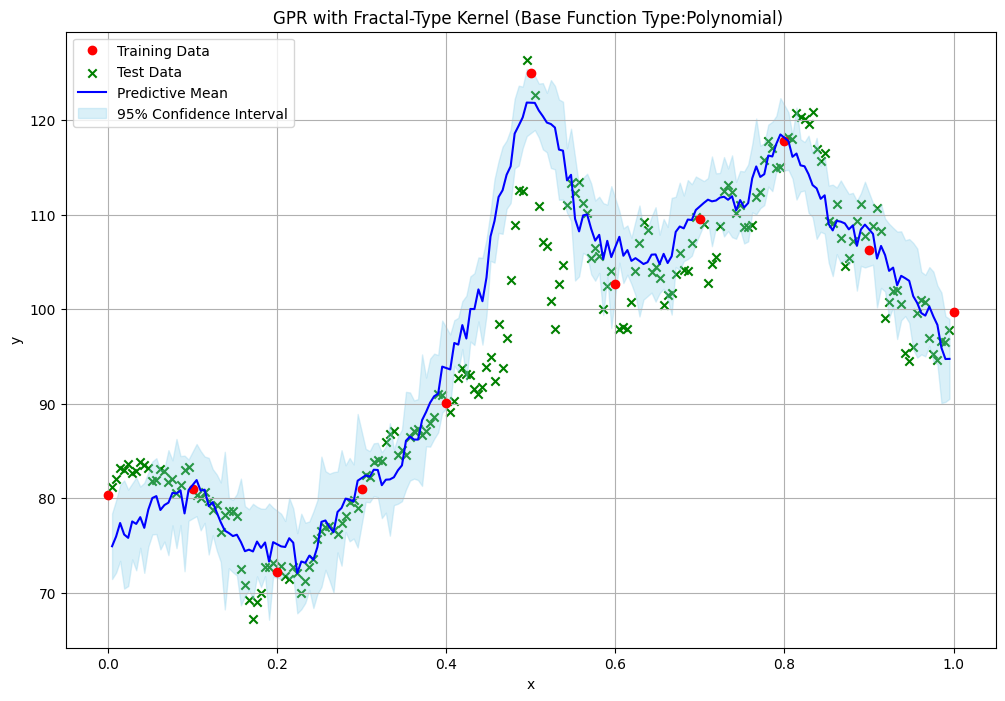

Model Evaluation on Test Data:
Mean Squared Error (MSE): 29.9273
Mean Absolute Error (MAE): 3.9159
R-squared (R2): 0.8588


In [35]:
# Retrieve the best theta from the optimization results
# Ensure study and its results exist
try:
    best_theta = study.best_params["theta"]
    # Ensure F_matrix, B, X_grid, best_s_lists are available from the optimization step
    # If not, recompute them using the best parameters and the correct x_nodes (xB)
    # Recomputing here ensures they are based on the optimal parameters if the previous cell was skipped or failed after optimization
    eta = 11
    x_nodes = xB # Use xB as the nodes
    A, B, F_matrix, X_grid = compute_A_and_B_optimized(eta, best_s_lists, x_nodes)

except NameError:
    print("Error: Optuna study results (study) or required variables (best_s_lists, x_nodes) not found.")
    print("Please ensure the data loading/splitting, mean function, and Optuna optimization cells have run successfully.")
    # Exit or handle the error appropriately
    raise
except Exception as e:
    print(f"An error occurred while retrieving best parameters or recomputing basis functions: {e}")
    raise

# Use the correct X_train, Y_train, X_test, Y_test, sigma2, e_s defined in the data loading cell

# Build the kernel matrices using the updated fractal_kernel that handles arrays
K_train = fractal_kernel(X_train, X_train, F_matrix, B, X_grid, best_theta)
K_train += sigma2 * np.eye(len(X_train))
K_train += 1e-10 * np.eye(len(X_train)) # Add jitter for numerical stability

K_s = fractal_kernel(X_test, X_train, F_matrix, B, X_grid, best_theta)
K_ss = fractal_kernel(X_test, X_test, F_matrix, B, X_grid, best_theta)
K_ss += 1e-10 * np.eye(len(X_test)) # Add jitter to K_ss diagonal too for stability

# Handle potential singular matrix for K_train inverse
try:
    K_inv = inv(K_train)
except np.linalg.LinAlgError:
    print("Error: K_train matrix is singular or near-singular. Cannot compute inverse.")
    print("Consider increasing the jitter (1e-10) or checking the kernel function/hyperparameters.")
    # You might want to return or exit here
    raise

# Ensure xB and yB are available from earlier steps for the mean function
# They should be defined in the data loading/mean function cell

# Compute the predictive mean
# mu_s = m(X_test) + K_s @ K_train_inv @ (Y_train - m(X_train))
m_train_pred = priestley_chao_mean(X_train, xB, yB, d=0.05) # Mean function at training points
m_test_pred = priestley_chao_mean(X_test, xB, yB, d=0.05)   # Mean function at test points

# Using residuals e_s = Y_train - m(X_train)
# alpha = K_inv @ e_s
alpha = np.linalg.solve(K_train, e_s) # Use solve for stability instead of explicit inverse if possible

mu_s = m_test_pred + K_s @ alpha

# Compute the predictive covariance
cov_s = K_ss - K_s @ K_inv @ K_s.T

# Ensure the diagonal elements are non-negative before taking the square root
std_s = np.sqrt(np.maximum(np.diag(cov_s), 0))

# === Plot Final Prediction ===

plt.figure(figsize=(12, 8))
# Use the correct X_train and Y_train from the initial data split for plotting training data
plt.plot(X_train, Y_train, 'ro', label='Training Data')
plt.scatter(X_test, Y_test, color='green', label="Test Data", marker='x')
plt.plot(X_test, mu_s, 'b-', label='Predictive Mean')
# Plot confidence interval only for sorted X_test if plotting with fill_between
# To plot the filled area correctly, X_test and mu_s/std_s should ideally be sorted by X_test values
sort_indices = np.argsort(X_test)
X_test_sorted = X_test[sort_indices]
mu_s_sorted = mu_s[sort_indices]
std_s_sorted = std_s[sort_indices]

plt.fill_between(X_test_sorted, mu_s_sorted - 1.96 * std_s_sorted, mu_s_sorted + 1.96 * std_s_sorted, color='skyblue', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('GPR with Fractal-Type Kernel (Base Function Type:Polynomial) ')
plt.savefig("gpr_fractal_kernel.png", dpi=300, bbox_inches="tight")
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Compute Evaluation Metrics ===
mse = mean_squared_error(Y_test, mu_s)
mae = mean_absolute_error(Y_test, mu_s)
# R-squared score might not be the best metric for GPR directly, but can be computed
r2 = r2_score(Y_test, mu_s)

print(f"Model Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")